# 07 Nonlinear level-set learning

Nonlinear level-set learning is a nonlinear techniques for parameter space dimensionality reduction. It deforms the input space in order to make the target function constant along the inactive directions. It makes use of the recently introduced RevNets, and construct a nonlinear bijective map.

To look more into the details of the procedure see the original work [Learning nonlinear level sets for dimensionality reduction in function approximation](https://arxiv.org/abs/1902.10652). In this tutorial we are going to replicate some of the results of such paper, and compare them with the active subspaces technique.

<img src="nll_sketch.png">

Let's start by importing the classes we need to use. The only important thing here is to set the default type for the torch tensors.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from athena.active import ActiveSubspaces
from athena.nll import NonlinearLevelSet

torch.set_default_tensor_type(torch.DoubleTensor)

As example let's consider a simple cubic function in 2D:
$$
f(x_0, x_1) = x_0^3 + x_1^3 + 0.2 x_0 + 0.6 x_1.
$$

We uniformly sample the parameter space $[0, 1]^2$ obtaining 300 samples.

In [2]:
np.random.seed(42)

# global parameters
n_train = 300
n_params = 2

x_np = np.random.uniform(size=(n_train, n_params))
f = x_np[:, 0]**3 + x_np[:, 1]**3 + 0.2 * x_np[:, 0] + 0.6 * x_np[:, 1]
df_np = np.empty((n_train, n_params))
df_np[:, 0] = 3.0*x_np[:, 0]**2 + 0.2
df_np[:, 1] = 3.0*x_np[:, 1]**2 + 0.6 

### Active subspaces

Let's see how AS performs on such example. We can then compare the results with the application of the nonlinear level-set learning technique. The dimension of the active subspace is set to 1, and, since we have the exact gradients, we don't need to approximate them.

In [3]:
ss = ActiveSubspaces(1)
ss.fit(inputs=x_np, gradients=df_np)

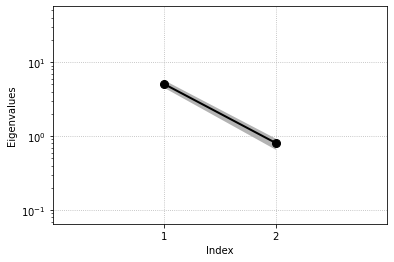

In [4]:
ss.plot_eigenvalues(figsize=(6, 4))

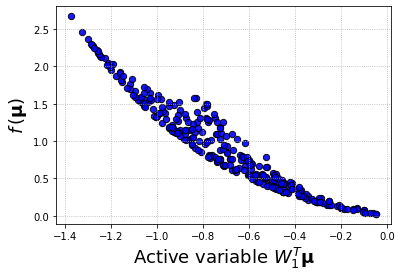

In [5]:
ss.plot_sufficient_summary(x_np, f, figsize=(6, 4))

### Nonlinear level-set learning

Now we train the reversible net to perform a nonlinear transformation of the input parameter space.

We create an instance of the `NonlinearLevelSet` class with the same active dimension as before and 10 layers. We also set the learning rate, the number of epochs, and the increment `dh` representating the "time step". The documentation of the class can be found [here](https://mathlab.github.io/ATHENA/nll.html). 

In [6]:
nll = NonlinearLevelSet(n_layers=10,
                        active_dim=1, 
                        lr=0.008,
                        epochs=1000,
                        dh=0.25)

To train the net, we need to convert the numpy arrays into torch tensors. Note that only inputs and gradients are needed for the train. 

The class `NonlinearLevelSet` allows also an interactive mode for which the plots of the loss function and sufficient summary are updated every 10 epochs. Here in the notebook we set `interactive=False` to not overload the kernel. You can set it to `True` in your local machine providing also che outputs in numpy format (refer to the [documentation](https://mathlab.github.io/ATHENA/_summaries/athena.nll.NonlinearLevelSet.train.html#athena.nll.NonlinearLevelSet.train) for more details).

In [7]:
x_torch = torch.as_tensor(x_np, dtype=torch.double)
df_torch = torch.as_tensor(df_np, dtype=torch.double)

In [8]:
nll.train(inputs=x_torch,
          gradients=df_torch,
          interactive=False)

epoch = 0, loss = 0.9678462328712224
epoch = 10, loss = 0.9568505024736955
epoch = 20, loss = 0.9462951050140015
epoch = 30, loss = 0.9361226988977548
epoch = 40, loss = 0.926276649514911
epoch = 50, loss = 0.9167014505150889
epoch = 60, loss = 0.9073428799421908
epoch = 70, loss = 0.8981479408337191
epoch = 80, loss = 0.889064630470931
epoch = 90, loss = 0.8800415743201602
epoch = 100, loss = 0.8710275515789376
epoch = 110, loss = 0.8619709302437716
epoch = 120, loss = 0.8528190213392572
epoch = 130, loss = 0.8435173546544197
epoch = 140, loss = 0.8340088720600786
epoch = 150, loss = 0.8242330292131854
epoch = 160, loss = 0.8141247921846829
epoch = 170, loss = 0.8036135124098487
epoch = 180, loss = 0.7926216617491052
epoch = 190, loss = 0.781063410192353
epoch = 200, loss = 0.7688430333923106
epoch = 210, loss = 0.7558531485100562
epoch = 220, loss = 0.7419727994500563
epoch = 230, loss = 0.7270654542669791
epoch = 240, loss = 0.7109770512630016
epoch = 250, loss = 0.6935343572059676


Now we can plot the loss function decay and compare the sufficient summary plots obtained with NLL and AS. We can clearly see how the NLL outperforms AS, with almost a perfect alignment of the data. AS, instead, presented a more scattered configuration.

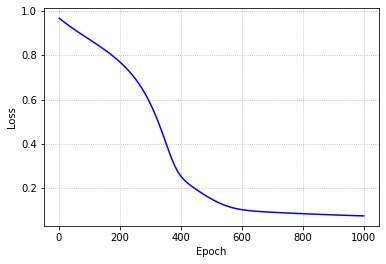

In [9]:
nll.plot_loss(figsize=(6, 4))

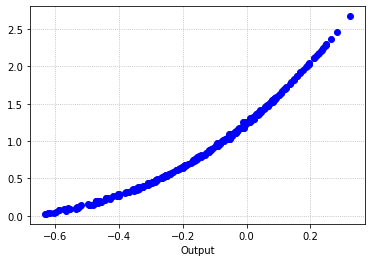

In [10]:
nll.plot_sufficient_summary(x_torch, f, figsize=(6, 4))

Let's define the following utility function to plot a grid representation of the 2D parameter space, before and after the nonlinear deformation found by the net.

In [11]:
def gridplot(grid_np, Nx=64, Ny=64, color='black', **kwargs):
    grid_1 = grid_np[:, 0].reshape(1, 1, Nx, Ny)
    grid_2 = grid_np[:, 1].reshape(1, 1, Nx, Ny)
    u = np.concatenate((grid_1, grid_2), axis=1)
    
    # downsample displacements
    h = np.copy(u[0, :, ::u.shape[2]//Nx, ::u.shape[3]//Ny])
    # now reset to actual Nx Ny that we achieved
    Nx = h.shape[1]
    Ny = h.shape[2]
    # adjust displacements for downsampling
    h[0, ...] /= float(u.shape[2])/Nx
    h[1, ...] /= float(u.shape[3])/Ny
    # put back into original index space
    h[0, ...] *= float(u.shape[2])/Nx
    h[1, ...] *= float(u.shape[3])/Ny
    
    plt.figure(figsize=(6, 4))
    # create a meshgrid of locations
    for i in range(Nx):
        plt.plot(h[0, i, :], h[1, i, :], color=color, **kwargs)
    for i in range(Ny):
        plt.plot(h[0, :, i], h[1, :, i], color=color, **kwargs)
    for ix, xn in zip([0, -1], ['B', 'T']):
        for iy, yn in zip([0, -1], ['L', 'R']):
            plt.plot(h[0, ix, iy], h[1, ix, iy], 'o', label='({xn},{yn})'.format(xn=xn, yn=yn))
    
    plt.axis('equal')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

As an example we create a 8x8 grid.

In [12]:
xx = np.linspace(0.0, 1.0, num=8)
yy = np.linspace(0.0, 1.0, num=8)
xxx, yyy = np.meshgrid(xx, yy)
mesh = np.concatenate((np.reshape(xxx, (8**2, 1)), np.reshape(yyy, (8**2, 1))), axis=1)

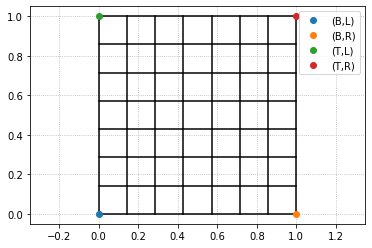

In [13]:
gridplot(mesh, Nx=8, Ny=8)

To plot the final nonlinear deformation of the parameter space, we need to feed the grid to the trained net.

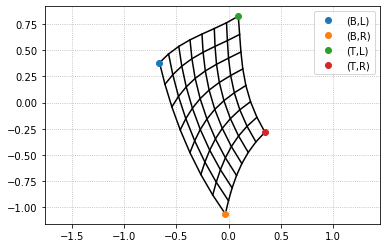

In [14]:
grid_torch = nll.forward(torch.from_numpy(mesh))
grid_np = grid_torch.detach().numpy()
gridplot(grid_np, Nx=8, Ny=8)

### Remarks

Try to play with the number of layers, the learning rate, and the time step. See how it performs for more complex examples, especially for those where AS struggles.